In [381]:
import os

import datetime

import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

import matplotlib.pyplot as plt

In [382]:
path_in='C:/Users/dkoch/Documents/Python Scripts/Booking Curves/Data'
path_out=path_in

In [383]:
files=os.listdir(path_in+'/Query Data')
files=[x for x in files if 'R_' not in x]
Data=pd.read_csv(path_in+'/Query Data/'+files[0],sep=';')
for f in files:
    Data_intermediate=pd.read_csv(path_in+'/Query Data/'+f,sep=';')
    Data=pd.concat([Data,Data_intermediate])
Data=Data.dropna(how='any')
Data.index=range(Data.shape[0])

Data=Data.rename(columns={'Extraction Day': 'IssueDate','Calendar day': 'DepDate','Sched Airport Depart': 'SegFrom',
'Sched Airport Arriva': 'SegTo','Pax total': 'NumPax','Flight Number': 'FltNum'})
Data['FltNum']=Data['FltNum'].apply(lambda x: str(x.split('-')[1]))
Data['NumPax']=Data['NumPax'].apply(lambda x: float(x.split(' ')[0]))

Data['DepDayMonth']=Data['DepDate'].apply(lambda x: x.split('/')[0]+'/'+x.split('/')[1])
Data['DepMonth']=Data['DepDate'].apply(lambda x: x.split('/')[1]+'/'+x.split('/')[2])

In [384]:
Map_AirportsToDirection=DataFrame([['SCN','TXL'],['TXL','SCN'],['O','I']]).transpose()
Map_AirportsToDirection.columns=['SegFrom','SegTo','Direction']
Data=Data.merge(Map_AirportsToDirection,on=['SegTo','SegFrom'])

In [385]:
Map_Flt_To_DepTime=pd.read_csv(path_in+'/Map Fln_To_DepTime/'+'SCNTXL.csv',sep=',')
Map_Flt_To_DepTime['FltNum']=Map_Flt_To_DepTime['FltNum'].astype('str')

Map_Flt_To_DepTime['DepDate']=Map_Flt_To_DepTime['DepDate'].apply(lambda x: '/'.join([x.split('-')[2],x.split('-')[1],x.split('-')[0]]) if '-' in x else x)
Map_Flt_To_DepTime['DepDay']=Map_Flt_To_DepTime['DepDate'].apply(lambda x: x.split('/')[0])
Map_Flt_To_DepTime['DepMonth']=Map_Flt_To_DepTime['DepDate'].apply(lambda x: x.split('/')[1])
Map_Flt_To_DepTime['DepYear']=Map_Flt_To_DepTime['DepDate'].apply(lambda x: x.split('/')[2])
Map_Flt_To_DepTime['DepDay']=Map_Flt_To_DepTime['DepDay'].apply(lambda x: '0'+x if len(x)==1 else x)
Map_Flt_To_DepTime['DepMonth']=Map_Flt_To_DepTime['DepMonth'].apply(lambda x: '0'+x if len(x)==1 else x)
Map_Flt_To_DepTime['DepDate']=Map_Flt_To_DepTime['DepDay']+'/'+Map_Flt_To_DepTime['DepMonth']+'/'+Map_Flt_To_DepTime['DepYear']

all_FlightNumbers=Map_Flt_To_DepTime['FltNum'].unique().tolist()
Data=Data.loc[Data['FltNum'].apply(lambda x: x in all_FlightNumbers),:]
Data.index=range(Data.shape[0])

Map_Flt_To_DepTime['DepDayMonth']=Map_Flt_To_DepTime['DepDate'].apply(lambda x: x.split('/')[0]+'/'+x.split('/')[1])
Map_Flt_To_DepTime['DepMonth']=Map_Flt_To_DepTime['DepDate'].apply(lambda x: x.split('/')[1]+'/'+x.split('/')[2])

Map_Flt_To_DepTime=Map_Flt_To_DepTime[['FltNum','DepDate','DepDayMonth','DepMonth','DepTime']]

In [386]:
Data=Data.merge(Map_Flt_To_DepTime,on=['FltNum','DepDate'],how='left')
Data=Data[[x for x in Data.columns if '_y' not in x]]
Data.columns=[x.replace('_x','') for x in Data.columns]
Data=Data.rename(columns={'DepTime': 'DepTime_mostgran'})

Data=Data.merge(Map_Flt_To_DepTime.drop_duplicates(subset=['FltNum','DepDayMonth']),on=['FltNum','DepDayMonth'],how='left')
Data=Data[[x for x in Data.columns if '_y' not in x]]
Data.columns=[x.replace('_x','') for x in Data.columns]
Data=Data.rename(columns={'DepTime': 'DepTime_lessgran'})

Data=Data.merge(Map_Flt_To_DepTime.drop_duplicates(subset=['FltNum','DepMonth']),on=['FltNum','DepMonth'],how='left')
Data=Data[[x for x in Data.columns if '_y' not in x]]
Data.columns=[x.replace('_x','') for x in Data.columns]
Data=Data.rename(columns={'DepTime': 'DepTime_leastgran'})

Data['DepTime']=np.nan

Data.loc[~pd.isnull(Data['DepTime_mostgran']),'DepTime']=Data.loc[~pd.isnull(Data['DepTime_mostgran']),'DepTime_mostgran']
Data.loc[pd.isnull(Data['DepTime_mostgran']),'DepTime']=Data.loc[pd.isnull(Data['DepTime_mostgran']),'DepTime_lessgran']
Data.loc[pd.isnull(Data['DepTime_mostgran'])&pd.isnull(Data['DepTime_lessgran']),'DepTime']\
        =Data.loc[pd.isnull(Data['DepTime_mostgran'])&pd.isnull(Data['DepTime_lessgran']),'DepTime_leastgran']

Data=Data.loc[~pd.isnull(Data['DepTime']),['IssueDate','DepDate','FltNum','SegTo','SegFrom','Direction','NumPax','DepTime']]

In [387]:
IssueDate=Data['IssueDate'].unique().tolist()
IssueDate_Map=DataFrame([IssueDate,
[pd.to_datetime(x.split(' ')[0],format='%d/%m/%Y') for x in IssueDate]]).transpose()
IssueDate_Map.columns=['IssueDate','NewFormat']

Data=Data.merge(IssueDate_Map,on=['IssueDate'])
Data=Data[[x for x in Data.columns if x!='IssueDate']]
Data=Data.rename(columns={'NewFormat': 'IssueDate'})

#######################################

DepartureDate=Data['DepDate'].unique().tolist()
DepartureDate_Map=DataFrame([DepartureDate,
[pd.to_datetime(x.split(' ')[0],format='%d/%m/%Y') for x in DepartureDate]]).transpose()
DepartureDate_Map.columns=['DepDate','NewFormat']
DepartureDate_Map['yday']=DepartureDate_Map['NewFormat'].apply(lambda x: x.timetuple().tm_yday)

DepartureDate_Map['dday_num']=DepartureDate_Map['NewFormat'].apply(lambda x: x.weekday())
Weekday_Map=DataFrame([range(0,8),['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]).transpose()
Weekday_Map.columns=['dday_num','dday']
DepartureDate_Map=DepartureDate_Map.merge(Weekday_Map,on='dday_num')
DepartureDate_Map=DepartureDate_Map[[x for x in DepartureDate_Map if x!='dday_num']]
DepartureDate_Map=DepartureDate_Map.sort_values(by='NewFormat')

Data=Data.merge(DepartureDate_Map,on=['DepDate'])
Data=Data[[x for x in Data.columns if x!='DepDate']]
Data=Data.rename(columns={'NewFormat': 'DepDate'})

#######################################

DepartureTime=Data['DepTime'].unique().tolist()
DepartureTime_Map=DataFrame([DepartureTime,[pd.to_datetime(x,format='%H:%M:%S') for x in DepartureTime]]).transpose()
DepartureTime_Map.columns=['DepTime','NewFormat']
DepartureTime_Map['dtime']=DepartureTime_Map['NewFormat'].apply(lambda x: (x-datetime.datetime.combine(x.date(),datetime.time(0,0))).seconds/60)

Data=Data.merge(DepartureTime_Map,on=['DepTime'])
Data=Data[[x for x in Data.columns if x!='DepTime']]
Data=Data.rename(columns={'NewFormat': 'DepTime'})

#######################################

Data['month']=Data['DepDate'].apply(lambda x: int(x.month))

#######################################

Data['Dprio']=(Data['DepDate']-Data['IssueDate']).apply(lambda x: float(x.days))
Data=Data[['DepDate','Dprio','yday','dtime','Direction','month','dday','NumPax']]
Data=Data.loc[(Data['Dprio']>0)&(Data['Dprio']<=366)&(Data['NumPax']>0),:]

Data=Data.sort_values(by=['DepDate','Dprio'],ascending=[True,False])
Data=Data.set_index(['DepDate','Dprio','yday','dtime','Direction','month','dday'])

In [388]:
Data=Data.groupby(level=[0,2,3,4,5,6]).diff().reset_index()
Data=Data.dropna(how='any')
Data_NoObs=Data.loc[:,['DepDate','yday','dtime','Direction','month','dday']].drop_duplicates()
distinct_flights=Data_NoObs.shape[0]
Data_NoObs.index=range(Data_NoObs.shape[0])
Data_NoObs=Data_NoObs.iloc[np.repeat([x for x in Data_NoObs.index],365),:]
Data_NoObs['Dprio']=[x for x in range(1,366)]*distinct_flights
Data_NoObs['NumPax']=0
Data_NoObs=Data[Data.columns]

Data_NoObs=pd.concat([Data,Data_NoObs])
Data=Data.drop_duplicates(subset=['DepDate','Dprio','yday','dtime','Direction','month','dday'])

Data=Data.sort_values(by=['DepDate','Dprio'],ascending=[True,False])

TrainingSet=Data.loc[Data['DepDate']<=pd.to_datetime('2018-10-31'),].copy()
TestSet=Data.loc[Data['DepDate']>pd.to_datetime('2018-12-31'),].copy()

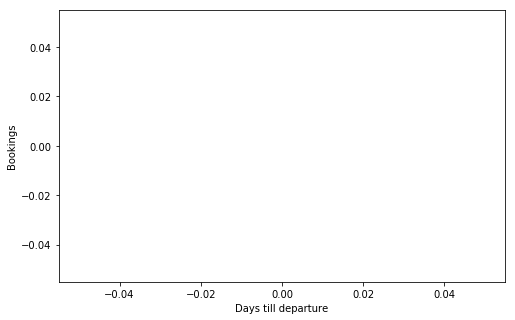

In [389]:
pick_date=TrainingSet['DepDate'].unique()[100]

plt.figure(1, figsize=(8, 5))

plt.plot(TrainingSet.loc[(TrainingSet['DepDate']==pick_date)&(TrainingSet['Direction']=='I')&(TrainingSet['dtime']==1130),'Dprio'],
TrainingSet.loc[(TrainingSet['DepDate']==pick_date)&(TrainingSet['Direction']=='I')&(TrainingSet['dtime']==1130),'NumPax'])

plt.xlabel('Days till departure')
plt.ylabel('Bookings')

plt.show()

# Booking Curves

In [390]:
BookingCurves=Data.copy()

BookingCurves['Dprio']=-BookingCurves['Dprio']
BookingCurves=BookingCurves.set_index(['DepDate','Dprio','dday','dtime','Direction','month','yday'])
BookingCurves=BookingCurves.groupby(level=[0,1,2,3,4,5,6]).sum().groupby(level=[0,2,3,4,5,6]).cumsum().reset_index()
BookingCurves['Dprio']=-BookingCurves['Dprio']

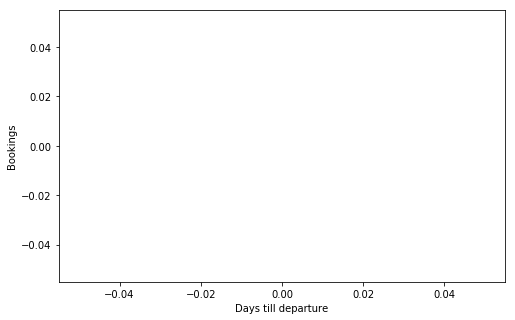

In [391]:
pick_date=BookingCurves['DepDate'].unique()[100]

plt.figure(1, figsize=(8, 5))

plt.plot(BookingCurves.loc[(BookingCurves['DepDate']==pick_date)&(BookingCurves['Direction']=='I')&(BookingCurves['dtime']==1130),'Dprio'],
BookingCurves.loc[(BookingCurves['DepDate']==pick_date)&(BookingCurves['Direction']=='I')&(BookingCurves['dtime']==1130),'NumPax'])

plt.xlabel('Days till departure')
plt.ylabel('Bookings')

plt.show()

# Aggregated data for preliminary experiments with glm function 

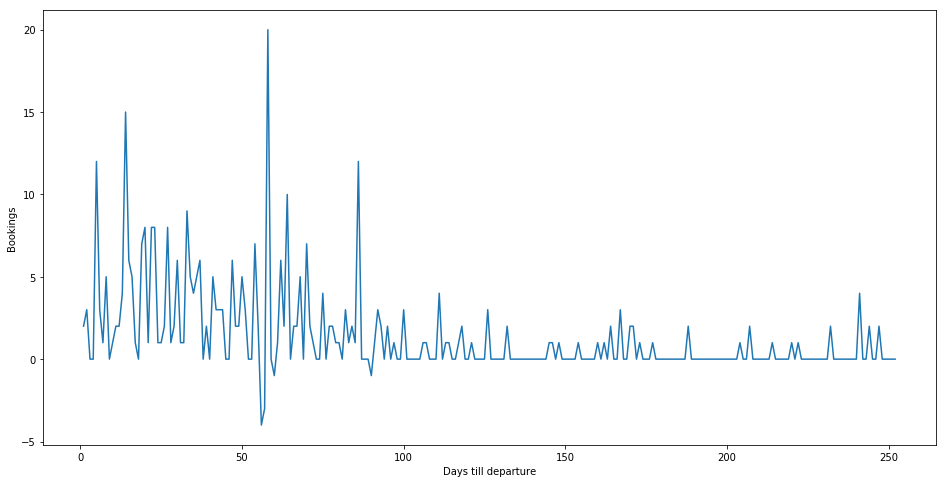

In [392]:
Data_AggrOverPartit=Data.groupby(['DepDate','Dprio'])['NumPax'].sum().reset_index()

pick_date=Data_AggrOverPartit['DepDate'].unique()[250]

plt.figure(1, figsize=(16, 8))

plt.plot(Data_AggrOverPartit.loc[(Data_AggrOverPartit['DepDate']==pick_date),'Dprio'],Data_AggrOverPartit.loc[(Data_AggrOverPartit['DepDate']==pick_date),'NumPax'])

plt.xlabel('Days till departure')
plt.ylabel('Bookings')

plt.show()

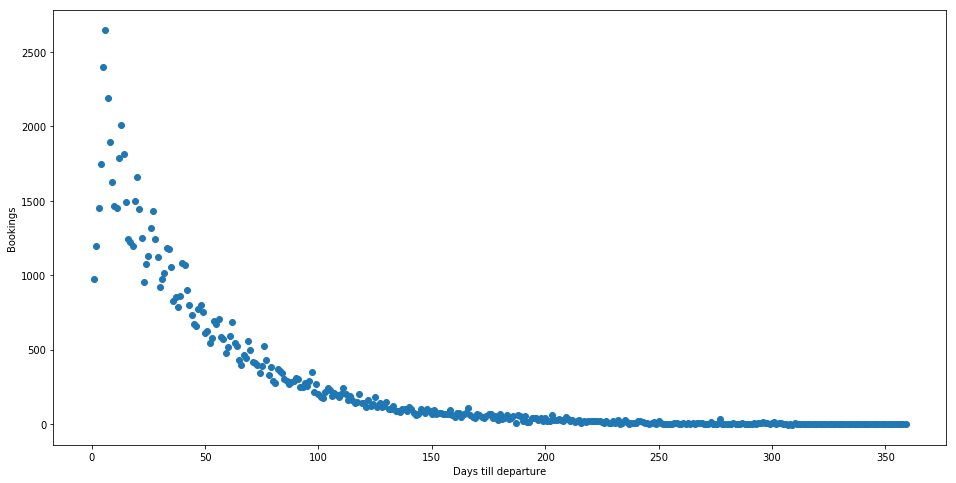

In [393]:
Data_AggrOverAll=Data.groupby('Dprio')['NumPax'].sum().reset_index()

plt.figure(1, figsize=(16, 8))

plt.plot(Data_AggrOverAll['Dprio'],Data_AggrOverAll['NumPax'],'o')

plt.xlabel('Days till departure')
plt.ylabel('Bookings')

plt.show()

# Data Output

In [394]:
TrainingSet.to_csv(path_out+'/Query Data/R_Training_Counting.csv',index=False)
TestSet.to_csv(path_out+'/Query Data/R_Test_Counting.csv',index=False)
BookingCurves.to_csv(path_out+'/Query Data/R_Input_Cumulated.csv',index=False)

# JUST FOR EXPERIMENTS
Data_AggrOverPartit.to_csv(path_out+'/Query Data/R_Input_AggrOverPartit.csv',index=False)
Data_AggrOverAll.to_csv(path_out+'/Query Data/R_Input_AggrOverAll.csv',index=False)

In [395]:
TrainingSet

,DepDate,Dprio,yday,dtime,Direction,month,dday,NumPax
12,2018-01-05,1.0,5,1110.0,O,1,Friday,0.0
13,2018-01-05,1.0,5,1220.0,I,1,Friday,1.0
14,2018-01-05,1.0,5,465.0,O,1,Friday,0.0
15,2018-01-05,1.0,5,825.0,O,1,Friday,0.0
16,2018-01-05,1.0,5,580.0,I,1,Friday,0.0
17,2018-01-05,1.0,5,950.0,I,1,Friday,1.0
20,2018-01-06,2.0,6,465.0,O,1,Saturday,0.0
21,2018-01-06,2.0,6,580.0,I,1,Saturday,0.0
22,2018-01-06,1.0,6,465.0,O,1,Saturday,0.0
23,2018-01-06,1.0,6,580.0,I,1,Saturday,2.0
